# install & import

In [1]:
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

In [2]:
import torch
import torchvision.transforms as T
from utils.stylePredictor26 import pretrainedStylePredictor
from utils.transform26 import pretrainedGhiasi

import clip
from utils.clip_loss import CLIPLoss
from PIL import Image

import torchvision.transforms as T
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

import imageio

In [3]:
imageio.read("doge.jpg")

In [4]:
device = ["cpu", "cuda"][torch.cuda.is_available()]

In [5]:
print("loading models")
SP = pretrainedStylePredictor().to(device)
G = pretrainedGhiasi().to(device)
print("done")

loading models
done


In [6]:
content_cap = 384
style_size = 256

style_preprocess = torch.nn.Sequential(
  T.Resize(style_size,),
  T.CenterCrop(style_size),
  torch.nn.AvgPool2d(kernel_size=3,stride=1)
)

content_preprocess = torch.nn.Sequential(
  T.Resize(content_cap,),
  T.CenterCrop(content_cap),
)

In [7]:
clip_loss = CLIPLoss(content_cap)

In [8]:
clip_loss.eval()
SP.eval()
G.eval()
pass

In [9]:
content_image_name = "doge.jpg"
content = Image.open(content_image_name).convert('RGB')
style = Image.open(content_image_name).convert('RGB')

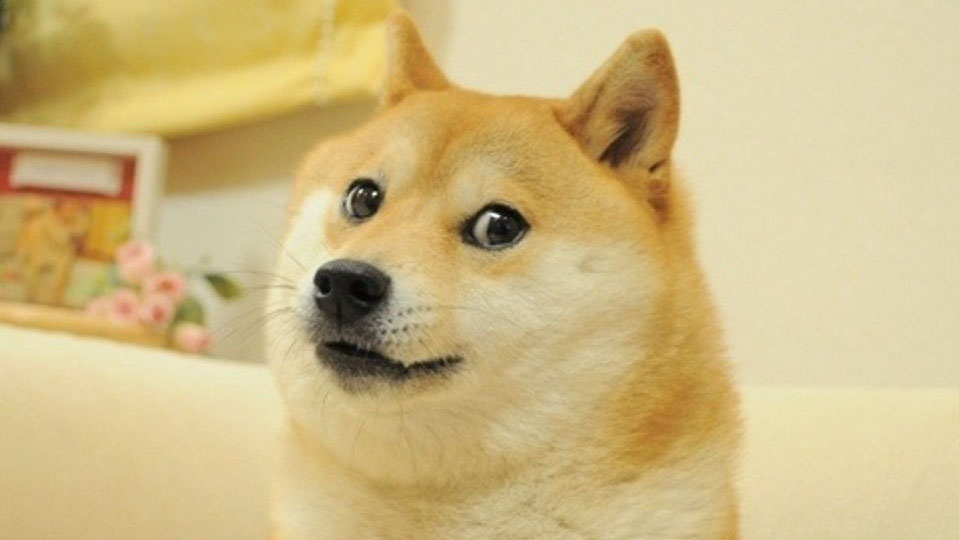

In [10]:
content

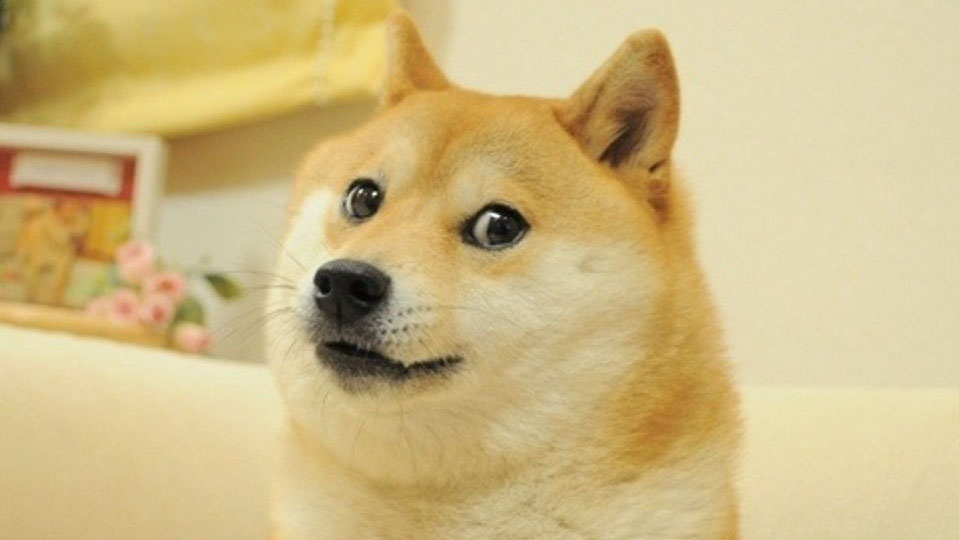

In [11]:
style

# config

In [12]:
FLAG_resize_center_crop_content = True

# Go get encode

In [13]:
content_tensor = T.ToTensor()(content)
content_tensor = content_preprocess(content_tensor)

style_tensor = T.ToTensor()(style)
style_tensor = style_preprocess(style_tensor)

content_tensor = content_tensor.unsqueeze(0).to(device)
style_tensor = style_tensor.unsqueeze(0).to(device)

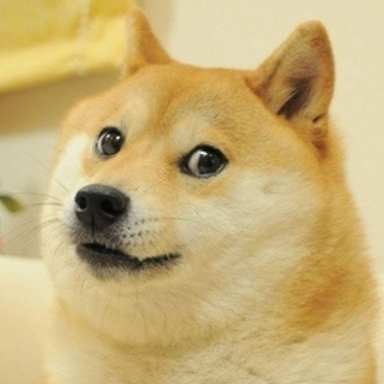

In [14]:
T.ToPILImage()(content_tensor.squeeze())

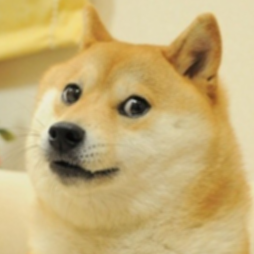

In [15]:
T.ToPILImage()(style_tensor.squeeze())

In [16]:
with torch.no_grad():
  style_code = SP(style_tensor)
  result = G(content_tensor, style_code)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


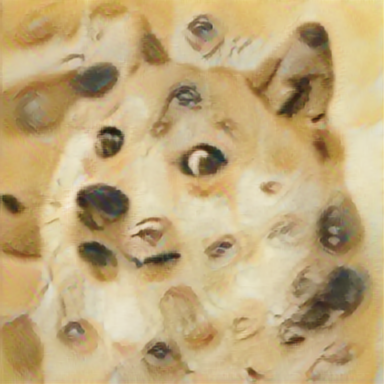

In [17]:
T.ToPILImage()(result.squeeze().cpu())

# Go CLIP

In [18]:
def tensor_to_numpy_image(tensor):
  return (255*tensor.detach().squeeze().cpu().permute(1,2,0).numpy()).astype(np.uint8)

In [24]:
steps = 100
save_step = steps//50
alpha = 1
beta = 0.01
lr = 0.01
augment_batches = 32

In [25]:
Aug = torch.nn.Sequential(
  T.RandomAffine(
    degrees=180,
    shear=5,
    scale=(1,1.5),
  ),
  T.ColorJitter(
    brightness=0.1,
    contrast=0.1,
    saturation=0.1,
    hue=0.1,
  ),
  T.RandomCrop(content_cap),
)

aug_fun = lambda img: torch.cat([Aug(img) for _ in range(batch_size)])

In [26]:
text_list = """\
green
blue
white
Vincent van Gogh's paint
small coffee beans
clouds
swirls
mosaic
Metal
hentai
jewels
jewels with square shape
green jewels
diamond
pudding
pumpkin
human
human mouth
honey
rose
golf ball
qr code
halloween
colorful dots
starry night\
"""

In [27]:
from pathlib import Path
Path("result_aug").mkdir(parents=True, exist_ok=True)

  0%|          | 0/25 [00:00<?, ?it/s]

green


  0%|          | 0/100 [00:00<?, ?it/s]

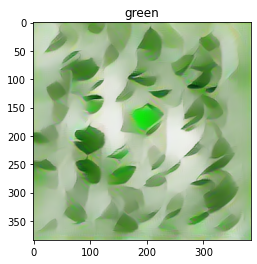

blue


  0%|          | 0/100 [00:00<?, ?it/s]

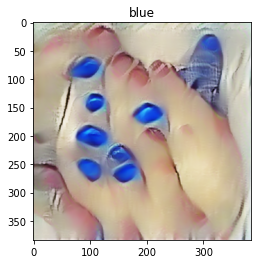

white


  0%|          | 0/100 [00:00<?, ?it/s]

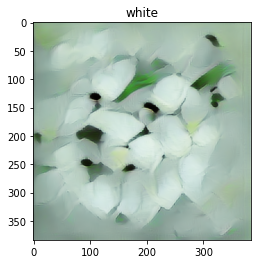

Vincent van Gogh's paint


  0%|          | 0/100 [00:00<?, ?it/s]

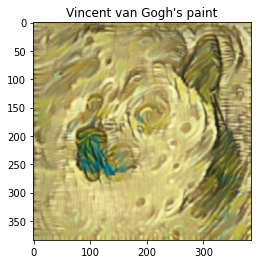

small coffee beans


  0%|          | 0/100 [00:00<?, ?it/s]

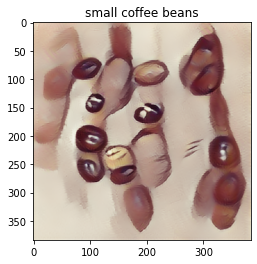

clouds


  0%|          | 0/100 [00:00<?, ?it/s]

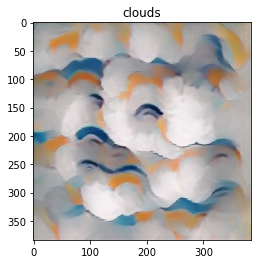

swirls


  0%|          | 0/100 [00:00<?, ?it/s]

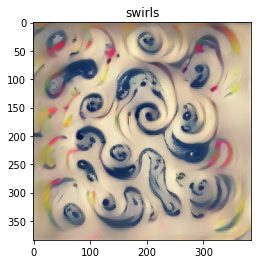

mosaic


  0%|          | 0/100 [00:00<?, ?it/s]

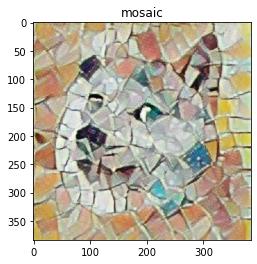

Metal


  0%|          | 0/100 [00:00<?, ?it/s]

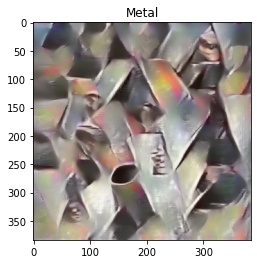

hentai


  0%|          | 0/100 [00:00<?, ?it/s]

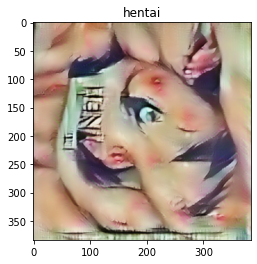

jewels


  0%|          | 0/100 [00:00<?, ?it/s]

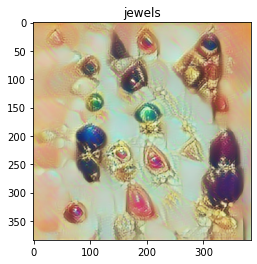

jewels with square shape


  0%|          | 0/100 [00:00<?, ?it/s]

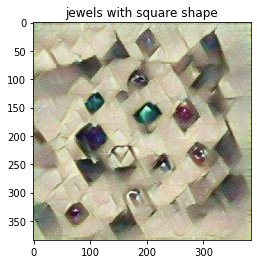

green jewels


  0%|          | 0/100 [00:00<?, ?it/s]

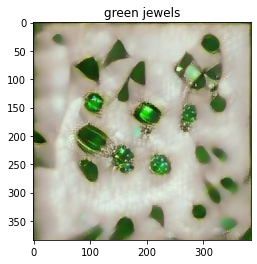

diamond


  0%|          | 0/100 [00:00<?, ?it/s]

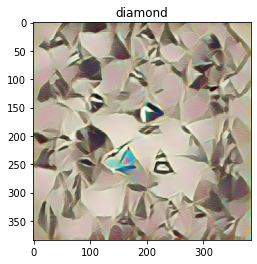

pudding


  0%|          | 0/100 [00:00<?, ?it/s]

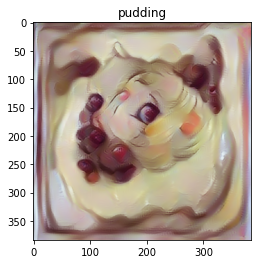

pumpkin


  0%|          | 0/100 [00:00<?, ?it/s]

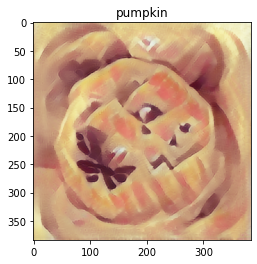

human


  0%|          | 0/100 [00:00<?, ?it/s]

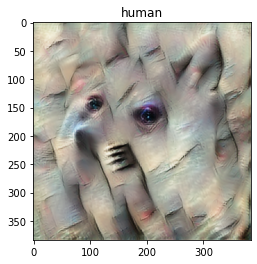

human mouth


  0%|          | 0/100 [00:00<?, ?it/s]

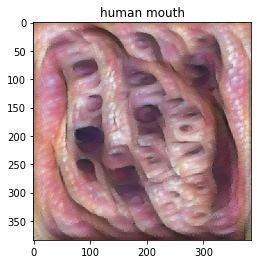

honey


  0%|          | 0/100 [00:00<?, ?it/s]

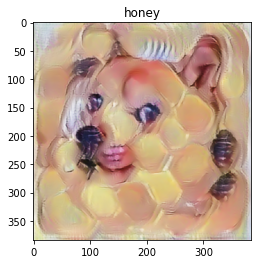

rose


  0%|          | 0/100 [00:00<?, ?it/s]

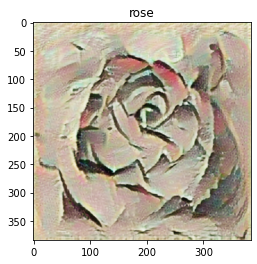

golf ball


  0%|          | 0/100 [00:00<?, ?it/s]

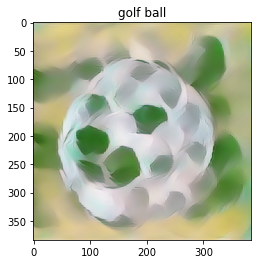

qr code


  0%|          | 0/100 [00:00<?, ?it/s]

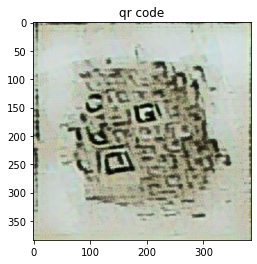

halloween


  0%|          | 0/100 [00:00<?, ?it/s]

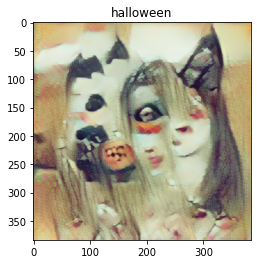

colorful dots


  0%|          | 0/100 [00:00<?, ?it/s]

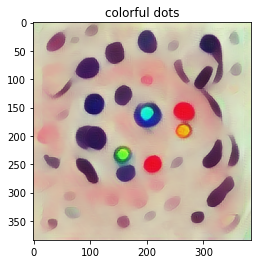

starry night


  0%|          | 0/100 [00:00<?, ?it/s]

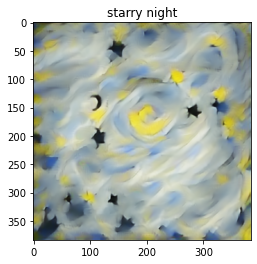

In [28]:
for text in tqdm(text_list.split("\n")):
  print(text)
  tokens = clip.tokenize([text]).to(device)
  code = style_code.clone()
  code.requires_grad_()
  optimizer = torch.optim.Adam([code],lr=lr)

  saved_code = []
  saved_result = []

  for idx in tqdm(range(steps)):
    result = G(content_tensor, code)
    batch_size = augment_batches
    
    aug_result = aug_fun(result)
    
    c_loss = clip_loss(aug_result, tokens)
    l2_loss = torch.sum((code-style_code)**2)

    loss = torch.mean((alpha*c_loss + beta*l2_loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (idx+1)%save_step == 0:
      saved_code.append(code.detach())
      saved_result.append(result.detach())
  
  
  plt.imshow(
    np.asarray(T.ToPILImage()(result.squeeze()))
  )
  plt.title(text)
  plt.show()
  
  imageio.mimwrite(f"result_aug/{text}.gif", [*map(tensor_to_numpy_image, saved_result)])